In [8]:
import pickle,random
import numpy as np
import gym
from scipy.optimize import linprog
from math import exp,pi,sqrt
import matplotlib.pyplot as plt
import mountain_car

In [3]:
# function to sample states

def get_sample_states(sample_trajs):
    sample_states_x = []
    sample_states_v = []
    x_range = list(range(113))

    # Sample x states
    for _ in range(sample_trajs):
        k = random.choice(x_range)
        x_range.remove(k)
        sample_states_x.append(k)

    v_range = list(range(120))
    # Sample v states
    for _ in range(sample_trajs):
        k = random.choice(v_range)
        v_range.remove(k)
        sample_states_v.append(k)

    sample_states_x.sort()
    sample_states_v.sort()

    S = []
    for i in sample_states_x:
        for j in sample_states_v:
            S.append([i, j])

    return S

In [4]:
# function to get next state

def get_next_state(s, a):
    x = x_binsize * s[0] + xmin   # discretized state to continuous state
    v = v_binsize * s[1] + vmin
    # print(x, v)
    env.reset()
    obs, R, done, info = env.step(a)

    return mountain_car.get_state(obs)          # continuous to discrete

In [5]:
# environment initialization

random.seed(0)
env = gym.make('MountainCar-v0')

e = env.env
discretization = 120
xmin = e.min_position
xmax = e.max_position
x_binsize = (xmax - xmin) / discretization

vmin = -1 * e.max_speed
vmax = e.max_speed
v_binsize = (vmax - vmin) / discretization

In [6]:
file_path = 'Q_opt.pkl'
# file_path = 'Data\\Q_Opt1'

with open(file_path, 'rb') as file:
    Q = pickle.load(file)

In [7]:
# print(Q)

# basis functions
num_of_basis = 26
scale = 0.5
basis_bin = (0.5 + 1.2) / (num_of_basis - 1)
basis = [-1.2 + basis_bin * i for i in range(num_of_basis - 1)] + [0.5]
print('Basis:', basis)

Basis: [-1.2, -1.132, -1.064, -0.996, -0.9279999999999999, -0.8599999999999999, -0.7919999999999999, -0.724, -0.6559999999999999, -0.5879999999999999, -0.5199999999999999, -0.45199999999999996, -0.3839999999999999, -0.31599999999999984, -0.2479999999999999, -0.17999999999999994, -0.11199999999999988, -0.04399999999999982, 0.024000000000000243, 0.09200000000000008, 0.16000000000000014, 0.2280000000000002, 0.29600000000000004, 0.3640000000000001, 0.43200000000000016, 0.5]


In [ ]:
for i in range(0, num_of_basis):
    mountain_car.get_value_function(Q, basis[i], scale, i)

In [11]:
V = []

for i in range(num_of_basis):
    file_path = 'V' + str(i)
    # file_path = 'Data\\V' + str(i)

    with open(file_path, 'rb') as file:
        V.append(pickle.load(file))

print(len(V[0][0]))

120


In [10]:
trj = 10
S0 = get_sample_states(trj)
print(len(S0))

100


In [12]:
alphas=None

# LP to calculate alphas for a linear combination of basis functions

c = [0] * num_of_basis + [-1] * len(S0)
bound = [(-1, 1) for i in range(num_of_basis)] + [(None, None) for j in range(len(S0))]
A = [[0 for i in range(len(c))] for j in range(4 * len(S0))]      # constraints matrix
b = [0 for j in range(4 * len(S0))]

for i in range(len(S0)):
    A[4 * i][num_of_basis + i] = 1
    A[4 * i + 1][num_of_basis + i] = 1
    A[4 * i + 2][num_of_basis + i] = 1
    A[4 * i + 3][num_of_basis + i] = 1

    a = np.argmax(np.array(Q[S0[i][0]][S0[i][1]]))
    actions = [0, 1, 2]
    actions.remove(a)
    a2 = actions[0]     # alternating actions
    a3 = actions[1]

    s = get_next_state(S0[i], a)
    s2 = get_next_state(S0[i], a2)
    s3 = get_next_state(S0[i], a3)

    fact = 3
    for j in range(num_of_basis):
        A[4 * i][j] = (-1 * V[j][s[0]][s[1]] + V[j][s2[0]][s2[1]]) / 10000
        A[4 * i + 1][j] = fact * (-1 * V[j][s[0]][s[1]] + V[j][s2[0]][s2[1]]) / 10000
        A[4 * i + 2][j] = (-1 * V[j][s[0]][s[1]] + V[j][s3[0]][s3[1]]) / 10000
        A[4 * i + 3][j] = fact * (-1 * V[j][s[0]][s[1]] + V[j][s3[0]][s3[1]]) / 10000

# Solve LP
print("Solving LP..")
res = linprog(c, A_ub=A, b_ub=b, bounds=bound)
print('Result: ', res)
alphas = list(res['x'])
alphas = alphas[:num_of_basis]
print('Alphas: ', alphas)

Solving LP..
Result:          message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.0
              x: [-1.000e+00 -1.000e+00 ... -0.000e+00 -0.000e+00]
            nit: 0
          lower:  residual: [ 0.000e+00  0.000e+00 ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [ 2.000e+00  2.000e+00 ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
                 marginals: [-1.000e+00 -0.000e+00 ... -0.000e+00
                             -0.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
     

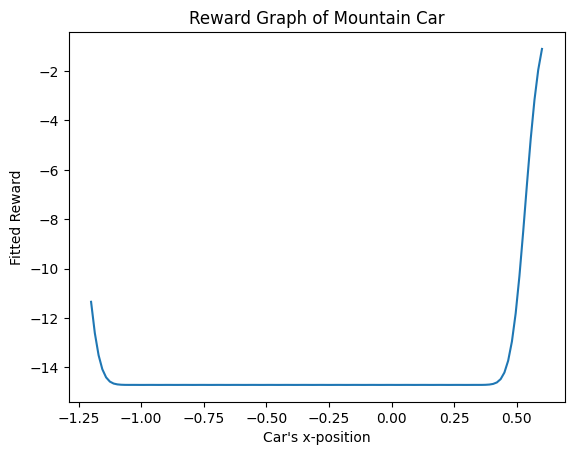

In [13]:
X = []
R = []    # Rewards

x = xmin
std = 0.05

while x <= xmax:
    X.append(x)
    rx = 0
    for k in range(len(basis)):
        rx += alphas[k] * mountain_car.calc_pdf(x, basis[k], std)
    R.append(rx)

    x += x_binsize


plt.figure(1)
plt.xlabel("Car's x-position")
plt.ylabel("Fitted Reward")
plt.title("Reward Graph of Mountain Car")
plt.plot(X, R)
plt.show()